In [2]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import statsmodels.api as sm

# macOS 한글 폰트 강제 지정
font_path = "/System/Library/Fonts/AppleSDGothicNeo.ttc"
font_prop = fm.FontProperties(fname=font_path)

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["axes.unicode_minus"] = False

sns.set_theme(style="whitegrid", font=font_prop.get_name())

import warnings

warnings.filterwarnings(
    "ignore",
    message="Glyph .* missing from font"
)



# 1. 데이터 로드 & 기본 전처리

In [3]:
import pandas as pd

df = pd.read_csv("./outputs/data/df_2.csv")

# 2. ANOVA: 계절 간 평균 판매량 차이 검정

- Figure X는 자유도에 따른 F 분포의 변화를 나타내며,
본 연구에서 계산된 ANOVA F 통계량의 위치를 함께 표시하였다.
관측된 F 값은 해당 F 분포의 우측 꼬리 영역에 위치하며,
이는 관측된 계절 간 평균 판매량 차이가
우연히 발생할 확률이 매우 낮음을 의미한다.
따라서 계절에 따른 평균 판매량 차이는
통계적으로 유의한 것으로 판단된다.

In [7]:
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# -----------------------------
# 1) 계절별 판매량 요약
# -----------------------------
season_summary = df.groupby("계절")["EA"].agg(["count", "mean", "std"]).reset_index()
print("\n=== 계절별 EA 요약 통계 ===")
print(season_summary)

# -----------------------------
# 2) 일원배치 ANOVA
#   귀무가설 H0: 계절별 평균 EA 는 모두 같다
# -----------------------------
groups = []
labels = []

for season, group in df.groupby("계절"):
    groups.append(group["EA"])
    labels.append(season)

anova_result = stats.f_oneway(*groups)

print("\n=== ANOVA: 계절 간 EA 평균 차이 검정 ===")
print("계절 그룹:", labels)
print(f"F-statistic: {anova_result.statistic:.4f}")
print(f"p-value    : {anova_result.pvalue:.6f}")

if anova_result.pvalue < 0.05:
    print("→ p < 0.05 이므로, 계절 간 평균 판매량 차이가 통계적으로 유의합니다.")
else:
    print("→ p ≥ 0.05 이므로, 계절 간 평균 판매량 차이가 유의하다고 보기 어렵습니다.")

    



=== 계절별 EA 요약 통계 ===
   계절  count       mean        std
0  가을   9133  52.335377  75.792559
1  겨울  10039  48.322044  60.460587
2   봄  11636  54.359660  82.840271
3  여름  12058  50.866727  69.540580

=== ANOVA: 계절 간 EA 평균 차이 검정 ===
계절 그룹: ['가을', '겨울', '봄', '여름']
F-statistic: 13.0556
p-value    : 0.000000
→ p < 0.05 이므로, 계절 간 평균 판매량 차이가 통계적으로 유의합니다.


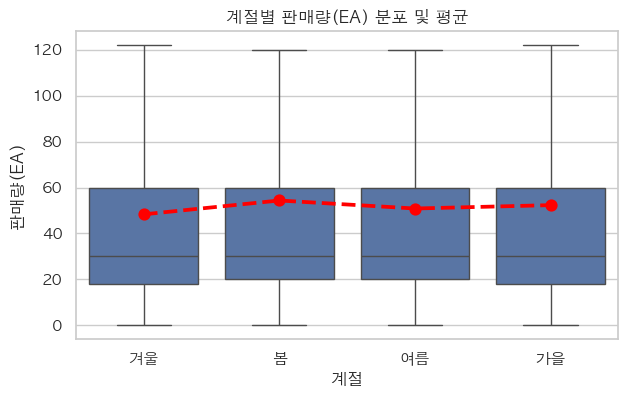

In [8]:
import seaborn as sns

plt.figure(figsize=(7,4))

sns.boxplot(
    x="계절",
    y="EA",
    data=df,
    showfliers=False
)

sns.pointplot(
    x="계절",
    y="EA",
    data=df,
    estimator=np.mean,
    color="red",
    markers="o",
    linestyles="--",
    errorbar=None
)

plt.title("계절별 판매량(EA) 분포 및 평균")
plt.xlabel("계절")
plt.ylabel("판매량(EA)")
plt.savefig("./outputs/figure/3.계절별판매량분포및평균.png", dpi=300, bbox_inches="tight")

plt.show()


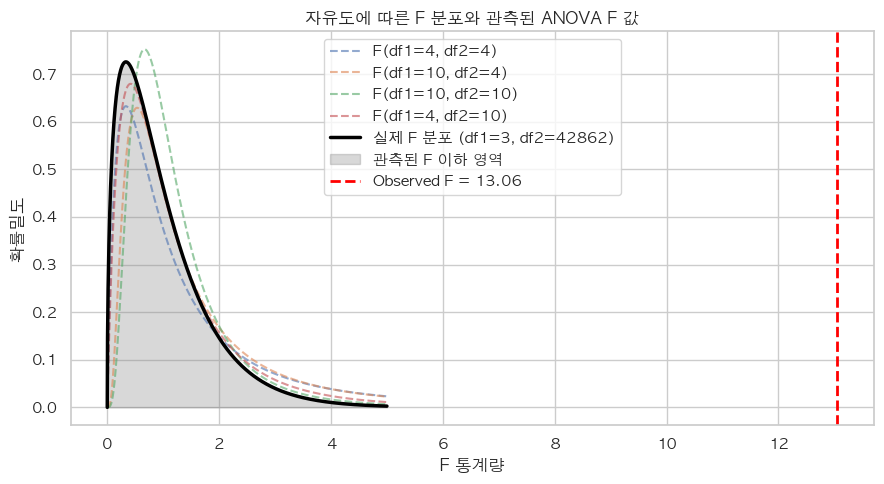

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# x축 범위
x = np.linspace(0, 5, 1000)

# 자유도 조합 (개념 비교용)
dfs = [
    (4, 4),
    (10, 4),
    (10, 10),
    (4, 10)
]

# === 내 ANOVA 결과 ===
F_obs = anova_result.statistic
p_val = anova_result.pvalue

df1_real = len(groups) - 1
df2_real = len(df) - len(groups)

# === Plot ===
plt.figure(figsize=(9,5))

# 1. 자유도별 F 분포 
for df1, df2 in dfs:
    y = f.pdf(x, df1, df2)
    plt.plot(
        x, y,
        linestyle="--",
        alpha=0.6,
        label=f"F(df1={df1}, df2={df2})"
    )

# 2️. 실제 ANOVA에 사용된 F 분포 
y_real = f.pdf(x, df1_real, df2_real)
plt.plot(
    x, y_real,
    color="black",
    linewidth=2.5,
    label=f"실제 F 분포 (df1={df1_real}, df2={df2_real})"
)

# 3. 관측된 F 값 기준 음영 (좌측 영역)
plt.fill_between(
    x, y_real,
    where=(x <= F_obs),
    color="gray",
    alpha=0.3,
    label="관측된 F 이하 영역"
)

# 4️. 관측된 F 값 수직선
plt.axvline(
    F_obs,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Observed F = {F_obs:.2f}"
)

# === 마무리 ===
plt.xlabel("F 통계량")
plt.ylabel("확률밀도")
plt.title("자유도에 따른 F 분포와 관측된 ANOVA F 값")
plt.legend()
plt.tight_layout()
plt.savefig("./outputs/figure/3.자유도에따른F분포와관측된ANOVAF값.png", dpi=300, bbox_inches="tight")

plt.show()


# 3. 다중회귀(OLS)로 기온·계절의 영향력 검증

* 종속변수: EA
* 독립변수: 기온 + 계절(범주형)
* C(계절)로 범주형 선언하면 알아서 더미 처리해줌

In [10]:
# -----------------------------
# 5) OLS 회귀모델
#    EA ~ 기온 + C(계절)
# -----------------------------
formula = "EA ~ 기온 + C(계절)"

ols_model = smf.ols(formula=formula, data=df).fit()

print("\n=== OLS 회귀분석 결과 ===")
print(ols_model.summary())

# 핵심 요약
print("\n=== 핵심 요약 ===")
print(f"Adj. R-squared: {ols_model.rsquared_adj:.4f}")
for param, pval in ols_model.pvalues.items():
    print(f"{param:15s}  p-value = {pval:.6f}")



=== OLS 회귀분석 결과 ===
                            OLS Regression Results                            
Dep. Variable:                     EA   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     11.53
Date:                Fri, 12 Dec 2025   Prob (F-statistic):           2.35e-09
Time:                        19:49:36   Log-Likelihood:            -2.4463e+05
No. Observations:               42866   AIC:                         4.893e+05
Df Residuals:                   42861   BIC:                         4.893e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      55.7638      1

In [11]:
import statsmodels.formula.api as smf

formula_corona = "EA ~ 기온 + C(계절) + 주말여부 + C(제로구분) + 코로나여부"

ols_corona = smf.ols(formula=formula_corona, data=df).fit()

print("\n=== OLS(코로나 포함) 회귀분석 결과 ===")
print(ols_corona.summary())

print("\n=== 핵심 요약 ===")
print(f"Adj. R-squared: {ols_corona.rsquared_adj:.4f}")
for param, pval in ols_corona.pvalues.items():
    print(f"{param:20s}  p-value = {pval:.6f}")



=== OLS(코로나 포함) 회귀분석 결과 ===
                            OLS Regression Results                            
Dep. Variable:                     EA   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     67.58
Date:                Fri, 12 Dec 2025   Prob (F-statistic):           1.78e-97
Time:                        19:49:36   Log-Likelihood:            -2.4442e+05
No. Observations:               42866   AIC:                         4.889e+05
Df Residuals:                   42858   BIC:                         4.889e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        

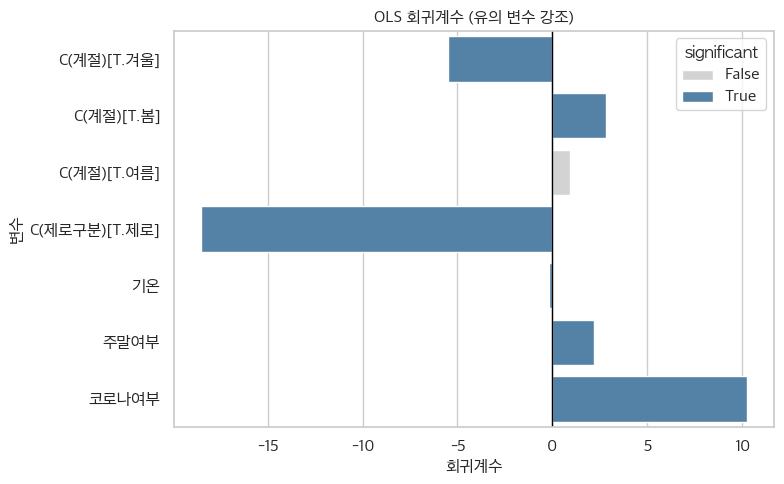

In [12]:
#OLS 회귀계수(Coef) Plot
coef_df = (
    pd.DataFrame({
        "variable": ols_corona.params.index,
        "coef": ols_corona.params.values,
        "stderr": ols_corona.bse.values,
        "pvalue": ols_corona.pvalues.values
    })
    .query("variable != 'Intercept'")
)

#유의 변수 강조 시각화
coef_df["significant"] = coef_df["pvalue"] < 0.05

plt.figure(figsize=(8, 5))

ax= sns.barplot(
    data=coef_df,
    x="coef",
    y="variable",
    hue="significant",
    palette={True: "steelblue", False: "lightgray"},
    legend=True
)

for label in ax.get_yticklabels():
    label.set_fontproperties(font_prop)

for label in ax.get_xticklabels():
    label.set_fontproperties(font_prop)

legend = ax.get_legend()
for text in legend.get_texts():
    text.set_fontproperties(font_prop)

plt.axvline(0, color="black", linewidth=1)
plt.title("OLS 회귀계수 (유의 변수 강조)", fontproperties=font_prop)
plt.xlabel("회귀계수", fontproperties=font_prop)
plt.ylabel("변수", fontproperties=font_prop)

plt.tight_layout()
plt.savefig("./outputs/figure/3.OLS회귀계수.png", dpi=300, bbox_inches="tight")

plt.show()


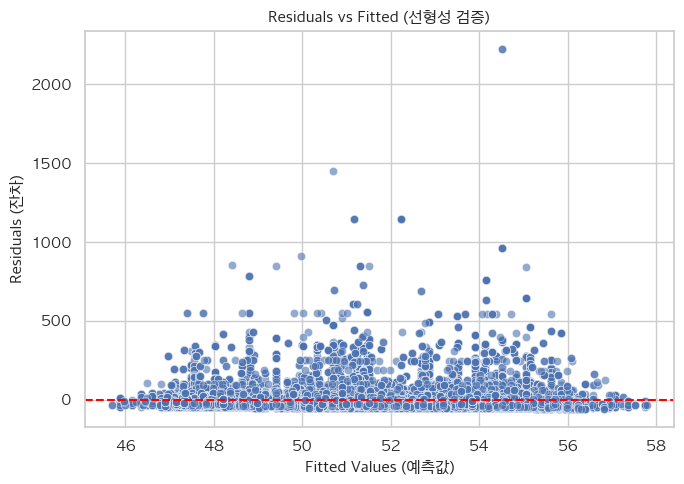

In [13]:
#Residuals vs Fitted Plot
fitted = ols_model.fittedvalues
residuals = ols_model.resid

plt.figure(figsize=(7, 5))
sns.scatterplot(x=fitted, y=residuals, alpha=0.6)

plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Fitted (선형성 검증)", fontproperties=font_prop)
plt.xlabel("Fitted Values (예측값)", fontproperties=font_prop)
plt.ylabel("Residuals (잔차)", fontproperties=font_prop)

plt.tight_layout()
plt.savefig("./outputs/figure/3.선형성검증.png", dpi=300, bbox_inches="tight")

plt.show()


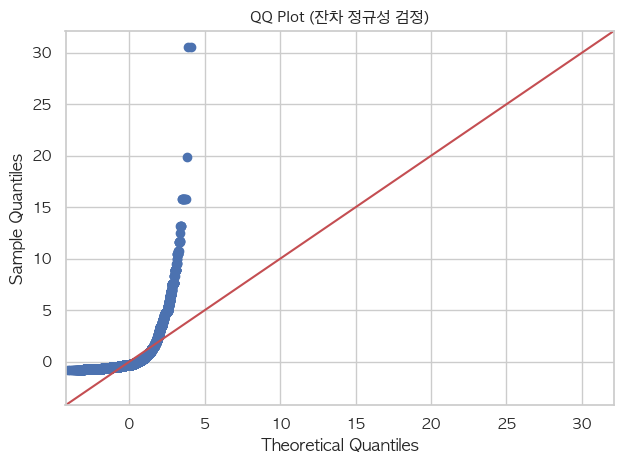

In [14]:
# QQ Plot (잔차 정규성)
fig = sm.qqplot(residuals, line="45", fit=True)
plt.title("QQ Plot (잔차 정규성 검정)", fontproperties=font_prop)
plt.tight_layout()
plt.savefig("./outputs/figure/3.잔차정규성검정.png", dpi=300, bbox_inches="tight")

plt.show()


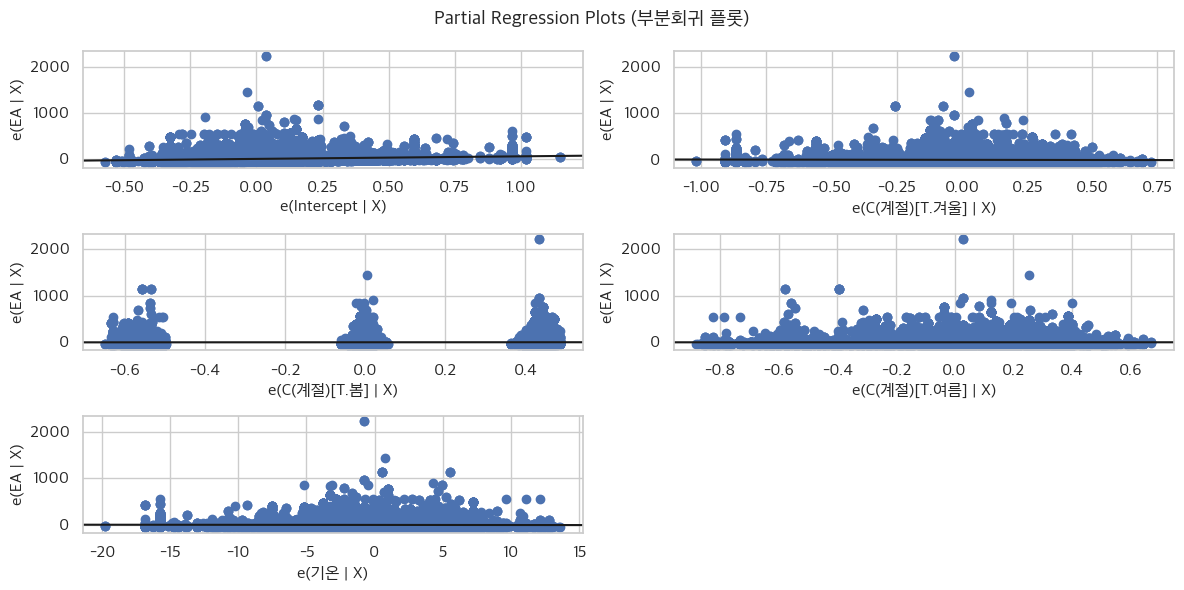

In [15]:
# Partial Regression Plots
fig = plt.figure(figsize=(12, 6))
sm.graphics.plot_partregress_grid(ols_model, fig=fig)

#  모든 Axes에 대해 폰트 강제 적용
for ax in fig.axes:
    # x, y 축 라벨
    ax.set_xlabel(ax.get_xlabel(), fontproperties=font_prop)
    ax.set_ylabel(ax.get_ylabel(), fontproperties=font_prop)

    # tick labels
    for label in ax.get_xticklabels():
        label.set_fontproperties(font_prop)
    for label in ax.get_yticklabels():
        label.set_fontproperties(font_prop)

# figure 제목
fig.suptitle(
    "Partial Regression Plots (부분회귀 플롯)",
    fontproperties=font_prop,
    fontsize=14
)

plt.tight_layout()
plt.savefig("./outputs/figure/3.부분회귀플롯.png", dpi=300, bbox_inches="tight")

plt.show()



# 4. VIF


| VIF 값 | 해석                 |
| ----- | ------------------ |
| 1~5   | 다중공선성 문제 없음 (정상) |
| 5~10  | 약간 높음(주의)        |
| 10 이상 | 심각한 다중공선성 문제     |


## VIF 결과

다중공선성 검증을 위해 VIF(Variance Inflation Factor)를 산출한 결과,
모든 변수의 VIF 값이 5 미만(1.00~4.46)으로 나타나
기온, 계절, 제로구분, 주말여부, 코로나여부 간의 다중공선성 문제는 없는 것으로 확인되었다.
따라서 OLS 회귀에서 기온·계절·주말·제로구분 변수가 비유의하게 나타난 원인은
다중공선성이 아니라, 해당 변수들이 실제 판매량 변동을
구조적으로 설명하지 못하는 요인임을 의미한다.
이는 1단계 통계분석의 결론을 더욱 강화하며,
이후 예측 모델에서는 기온·계절보다는
시차(Lag), 이동평균, 지역·상품 특성, 코로나 여부와 같은
시계열·외생 변수 중심의 특성 공학(Feature Engineering)이 필요함을 시사한다.


In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import pandas as pd

# 1) 제로구분 더미화
df_vif = df.copy()
df_vif["제로구분_제로"] = (df_vif["제로구분"] == "제로").astype(int)

# 2) 계절 더미 생성 (가을이 기준)
season_dummies = pd.get_dummies(df_vif["계절"], prefix="계절", drop_first=True)
df_vif = pd.concat([df_vif, season_dummies], axis=1)

# 3) VIF에 넣을 변수 목록
vif_vars = [
    "기온",
    "계절_겨울", "계절_봄", "계절_여름",
    "제로구분_제로",
    "주말여부",
    "코로나여부"
]

X = df_vif[vif_vars]
X = sm.add_constant(X)
X = X.astype(float)

# 4) VIF 계산
vif = pd.DataFrame()
vif["변수"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


        변수        VIF
0    const  19.439134
1       기온   4.211406
2    계절_겨울   3.116801
3     계절_봄   1.675629
4    계절_여름   2.589710
5  제로구분_제로   1.010389
6     주말여부   1.058976
7    코로나여부   1.031911


# 4. Feture Engineering

📌 시차(lag) 변수

lag_1과 lag_7은 각각 전일 판매량과 일주일 전 판매량을 의미하며,
판매량 시계열 특성상 과거 값이 미래 값을 강하게 설명하는 구조를 반영한다.
lag_7은 요일 반복 패턴(weekly cycle)을 포착하는 핵심 변수이다.

📌 이동평균(rolling mean) 변수

rolling_mean_7은 최근 7일의 평균 판매량으로,
단기 추세(trend)와 계절성을 동시에 부드럽게 포착한다.

📌 이동표준편차(rolling std) 변수

rolling_std_7은 최근 판매량 변동성을 나타내며,
프로모션, 공급 차질, 코로나 정책 등 외생 요인에 의해 발생하는
수요 급증·급락을 탐지하는데 유용하다.

In [18]:
import pandas as pd
import numpy as np

def make_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    판매량 예측 연구를 위한 Feature Engineering (주말여부 컬럼이 이미 존재하는 버전)
    """

    df = df.copy()

    # -----------------------------
    # 1. 날짜 정리
    # -----------------------------
    df["판매일"] = pd.to_datetime(df["판매일"], errors="coerce")

    # 지역 + 상품 기준 정렬
    group_cols = ["시도", "시군", "구", "상품명_cleaned"]
    df = df.sort_values(group_cols + ["판매일"])

    # -----------------------------
    # 2. 날짜 기반 피처
    # -----------------------------
    df["year"] = df["판매일"].dt.year
    df["month"] = df["판매일"].dt.month
    df["day"] = df["판매일"].dt.day
    df["dayofweek"] = df["판매일"].dt.dayofweek  # 0=월,6=일


    # 년월 문자형
    df["year_month"] = df["판매일"].dt.to_period("M").astype(str)

    # -----------------------------
    # 3. Lag Features (시차)
    # -----------------------------
    df["lag_1"] = df.groupby(group_cols)["EA"].shift(1)
    df["lag_7"] = df.groupby(group_cols)["EA"].shift(7)

    # -----------------------------
    # 4. Rolling Features
    # -----------------------------
    df["rolling_mean_7"] = (
        df.groupby(group_cols)["EA"]
          .apply(lambda s: s.shift(1).rolling(window=7, min_periods=1).mean())
          .reset_index(level=group_cols, drop=True)
    )

    df["rolling_std_7"] = (
        df.groupby(group_cols)["EA"]
          .apply(lambda s: s.shift(1).rolling(window=7, min_periods=1).std())
          .reset_index(level=group_cols, drop=True)
    )

    # -----------------------------
    # 5. 결측치 처리
    # -----------------------------
    fill_cols = ["lag_1", "lag_7", "rolling_mean_7", "rolling_std_7"]
    df[fill_cols] = df[fill_cols].fillna(0)

    return df


In [19]:
df= make_features(df).copy()

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import pandas as pd

# 1) 제로구분 더미화
df_vif = df.copy()
df_vif["제로구분_제로"] = (df_vif["제로구분"] == "제로").astype(int)

# 2) 계절 더미 생성 (가을이 기준)
season_dummies = pd.get_dummies(df_vif["계절"], prefix="계절", drop_first=True)
df_vif = pd.concat([df_vif, season_dummies], axis=1)

# 3) VIF에 넣을 변수 목록
vif_vars = [
    '기온',
    '코로나여부',
    '주말여부',
    # 계절 더미
    '계절_봄', '계절_여름', '계절_겨울',
    # 제로 여부 더미
    '제로구분_제로',
    # 시계열 파생변수
    'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7'
]

X = df_vif[vif_vars]
X = sm.add_constant(X)
X = X.astype(float)

# 4) VIF 계산
vif = pd.DataFrame()
vif["변수"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


                변수        VIF
0            const  20.519203
1               기온   4.213206
2            코로나여부   1.043007
3             주말여부   1.059412
4             계절_봄   1.675895
5            계절_여름   2.591082
6            계절_겨울   3.121420
7          제로구분_제로   1.020960
8            lag_1   1.973928
9            lag_7   1.916697
10  rolling_mean_7   4.585190
11   rolling_std_7   2.776993


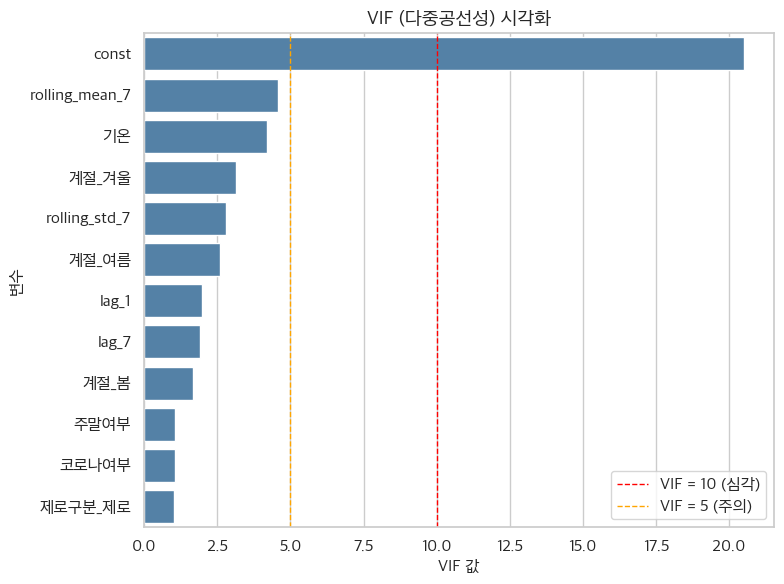

In [21]:
# 5-1) VIF Bar Chart
plt.figure(figsize=(8, 6))
vif_sorted = vif.sort_values("VIF", ascending=False)

ax = sns.barplot(
    data=vif_sorted,
    x="VIF",
    y="변수",
    color="steelblue"   # palette 제거 → FutureWarning 방지
)

# 🔥 tick label 폰트 강제
for label in ax.get_yticklabels():
    label.set_fontproperties(font_prop)
for label in ax.get_xticklabels():
    label.set_fontproperties(font_prop)

plt.title("VIF (다중공선성) 시각화", fontproperties=font_prop, fontsize=14)
plt.xlabel("VIF 값", fontproperties=font_prop)
plt.ylabel("변수", fontproperties=font_prop)

# 임계선
plt.axvline(10, color="red", linestyle="--", linewidth=1, label="VIF = 10 (심각)")
plt.axvline(5, color="orange", linestyle="--", linewidth=1, label="VIF = 5 (주의)")

legend = plt.legend(loc="lower right")
for text in legend.get_texts():
    text.set_fontproperties(font_prop)

plt.tight_layout()
plt.savefig("./outputs/figure/3.VIF.png", dpi=300, bbox_inches="tight")

plt.show()


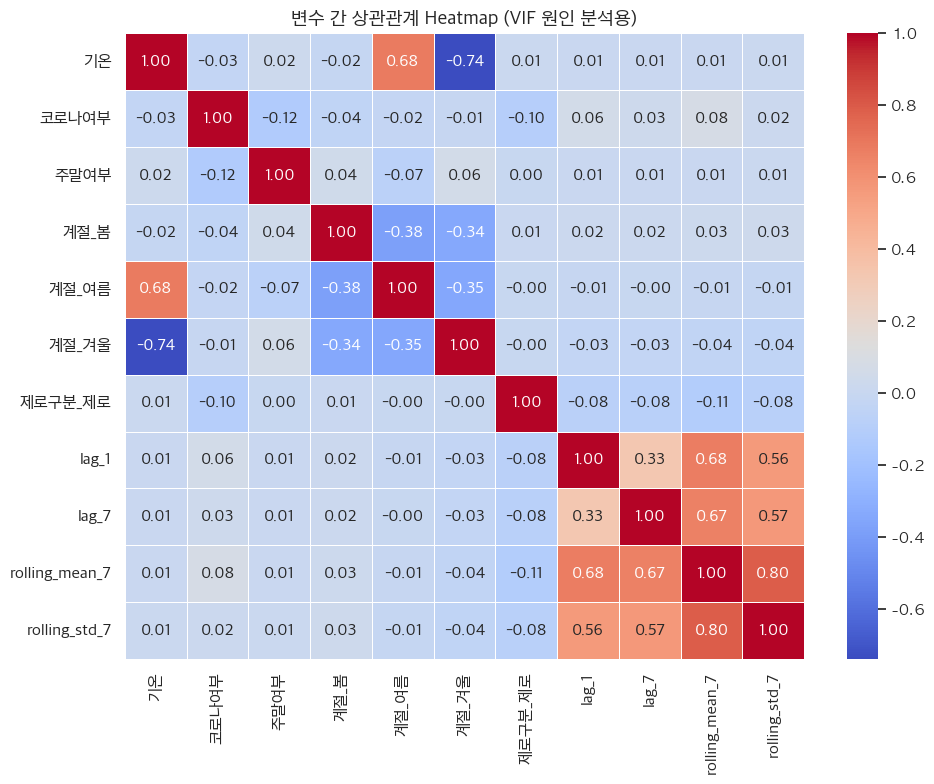

In [22]:
# 상관행렬 Heatmap
plt.figure(figsize=(10, 8))

corr = X[vif_vars].corr()

ax = sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)

# tick label 폰트
for label in ax.get_xticklabels():
    label.set_fontproperties(font_prop)
for label in ax.get_yticklabels():
    label.set_fontproperties(font_prop)

# annot 텍스트 폰트
for text in ax.texts:
    text.set_fontproperties(font_prop)

plt.title(
    "변수 간 상관관계 Heatmap (VIF 원인 분석용)",
    fontproperties=font_prop,
    fontsize=14
)

plt.tight_layout()
plt.savefig("./outputs/figure/3.VIF히트맵.png", dpi=300, bbox_inches="tight")

plt.show()


In [23]:
output_path = "./outputs/data/df_3.csv"
df.to_csv(output_path, index=False)
print(f"DataFrame을 {output_path} 에 성공적으로 저장했습니다.")


DataFrame을 ./outputs/data/df_3.csv 에 성공적으로 저장했습니다.
